In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import requests
import tensorflow_datasets as tfds
from tqdm import tqdm
import os
import shutil

data = tfds.load('beans')

/home/anton/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-26 19:47:54.688463: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-26 19:47:54.690013: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-26 19:47:54.691640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (anton): /proc/driver/nvidia/version does not exist
2023-03-26 19:47:54.694283: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

In [3]:
train_data = data['train'].skip(200).take(400)
test_data = data['train'].take(200)

@tf.function
def build_data(data):
  cropped = tf.dtypes.cast(tf.image.random_crop(data['image'] / 255,(128,128,3)),tf.float32)

  lr = tf.image.resize(cropped,(64,64))
  lr = tf.image.resize(lr,(128,128), method = tf.image.ResizeMethod.BICUBIC)
  return (lr,cropped)

def downsample_image(image,scale):
  lr = tf.image.resize(image / 255,(image.shape[0]//scale, image.shape[1]//scale))
  lr = tf.image.resize(lr,(image.shape[0], image.shape[1]), method = tf.image.ResizeMethod.BICUBIC)
  return lr

2023-03-26 19:47:56.111353: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


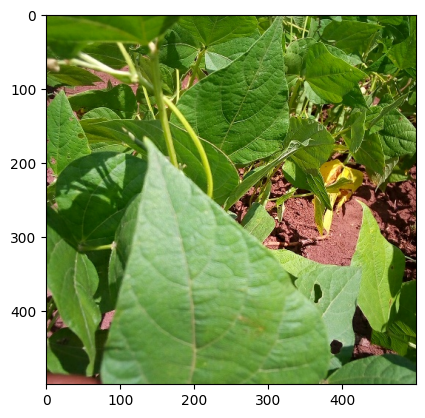

In [4]:
for x in train_data.take(1):
  plt.imshow(x['image'])
  plt.show()

2023-03-26 19:47:57.781398: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


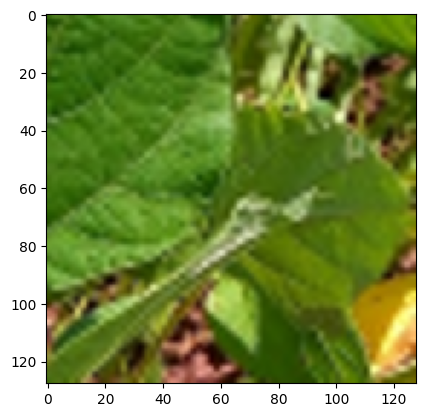

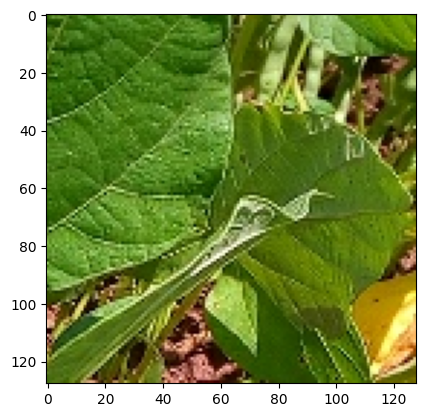

In [5]:
train_dataset_mapped = train_data.map(build_data, num_parallel_calls = tf.data.AUTOTUNE)

for x in train_dataset_mapped.take(1):
  plt.imshow(x[0].numpy())
  plt.show()
  plt.imshow(x[1].numpy())
  plt.show()

In [6]:
SRCNN_915=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,9,padding='same',activation='relu'),
    tf.keras.layers.Conv2D(32,5,padding='same',activation='relu'),
    tf.keras.layers.Conv2D(7,3,padding='same',activation='relu'),
    tf.keras.layers.Conv2D(3,5,padding='same',activation='relu')
])

def pixel_mse_loss(y_true,y_pred):
  return tf.reduce_mean((y_true - y_pred) ** 2)

def PSNR(y_true,y_pred):
  mse=tf.reduce_mean((y_true - y_pred) ** 2)
  return 20 * log10(1 / (mse ** 0.5))

def log10(x):
  numerator = tf.log(x)
  denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

SRCNN_915.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=pixel_mse_loss)

In [7]:
for x in range(5):
  train_dataset_mapped = train_data.map(build_data, num_parallel_calls = tf.data.AUTOTUNE).batch(50)
  val_dataset_mapped = test_data.map(build_data, num_parallel_calls = tf.data.AUTOTUNE).batch(50)
  
  SRCNN_915.fit(train_dataset_mapped,epochs=1,validation_data=val_dataset_mapped)

6/8 [=====================>........] - ETA: 34s - loss: 0.1840

2023-03-26 19:49:45.423063: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


8/8 [==============================] - ETA: 0s - loss: 0.1607 

2023-03-26 19:50:20.838196: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


6/8 [=====================>........] - ETA: 30s - loss: 0.0495

2023-03-26 19:53:01.794844: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


8/8 [==============================] - ETA: 0s - loss: 0.0434 

2023-03-26 19:53:44.887118: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


6/8 [=====================>........] - ETA: 32s - loss: 0.0244

2023-03-26 19:55:37.610190: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


8/8 [==============================] - ETA: 0s - loss: 0.0238 

2023-03-26 19:56:15.771645: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


6/8 [=====================>........] - ETA: 32s - loss: 0.0214

2023-03-26 19:58:56.878629: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


8/8 [==============================] - ETA: 0s - loss: 0.0210 

2023-03-26 19:59:33.504088: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


6/8 [=====================>........] - ETA: 29s - loss: 0.0178

2023-03-26 20:01:07.530712: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


8/8 [==============================] - ETA: 0s - loss: 0.0176 

2023-03-26 20:01:49.460481: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


8/8 [==============================] - 135s 17s/step - loss: 0.0176 - val_loss: 0.0151


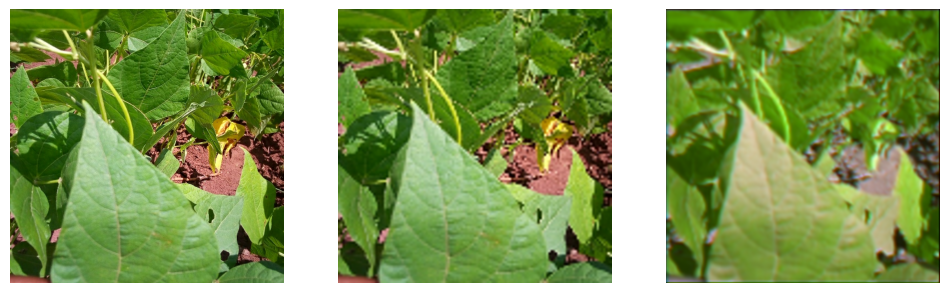

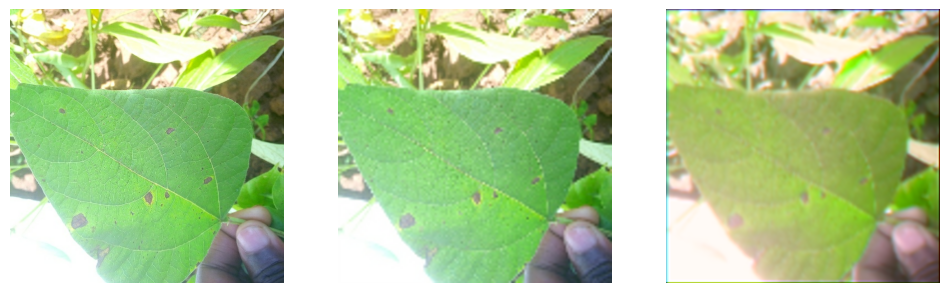

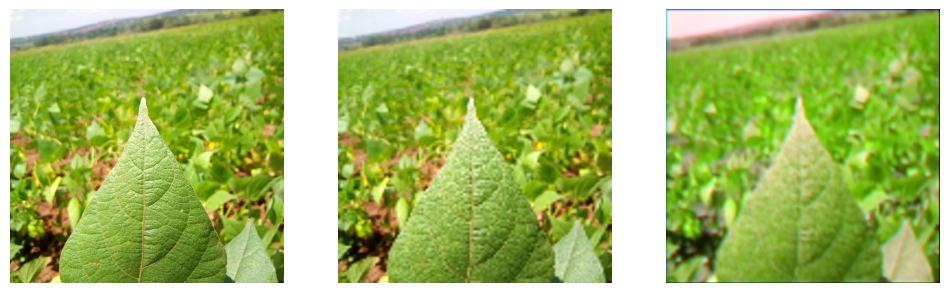

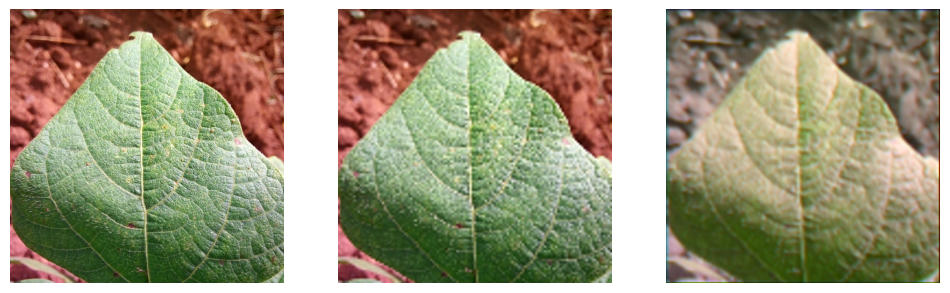

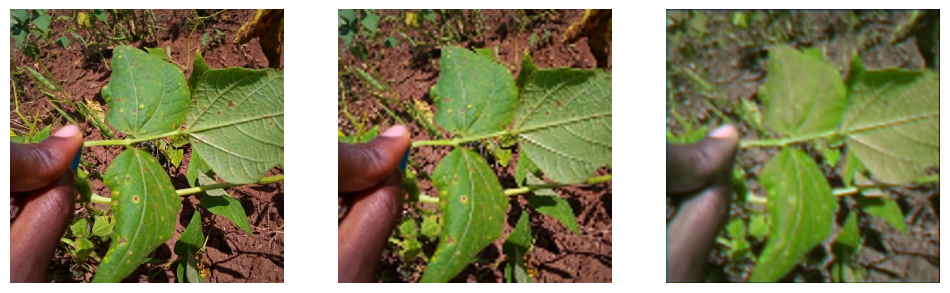

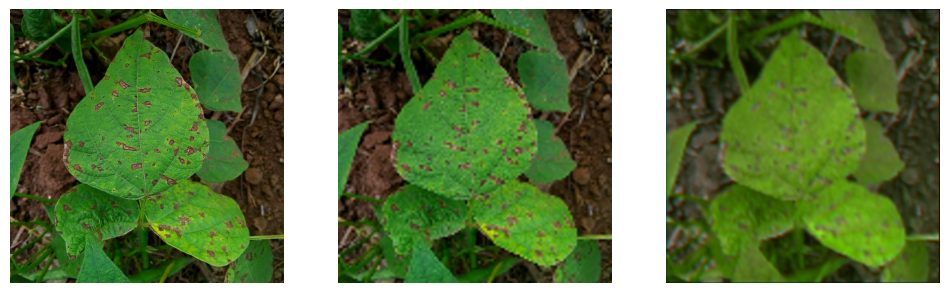

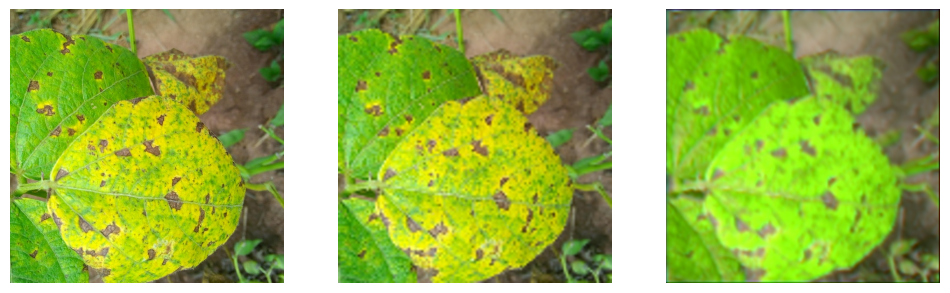

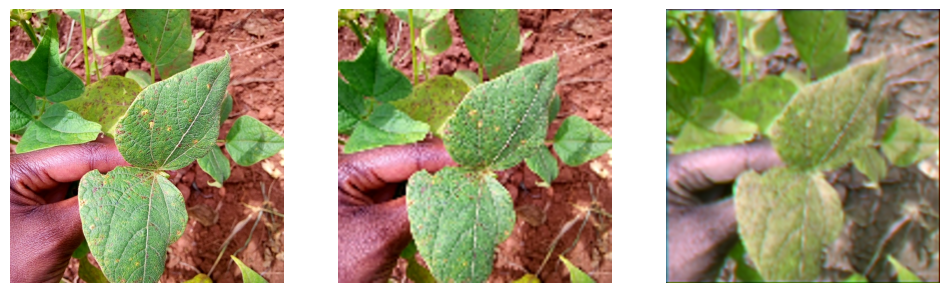

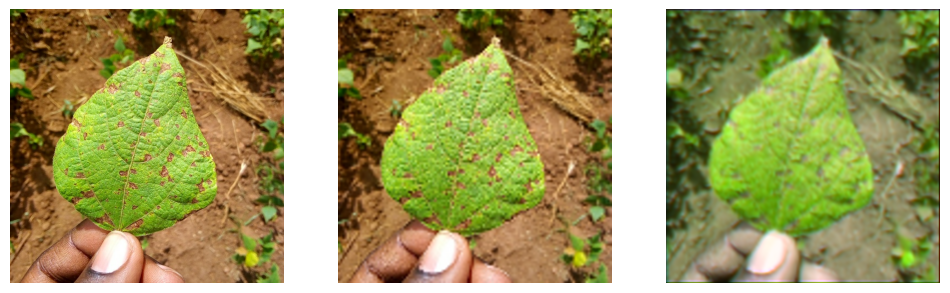

2023-03-26 20:02:17.012536: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


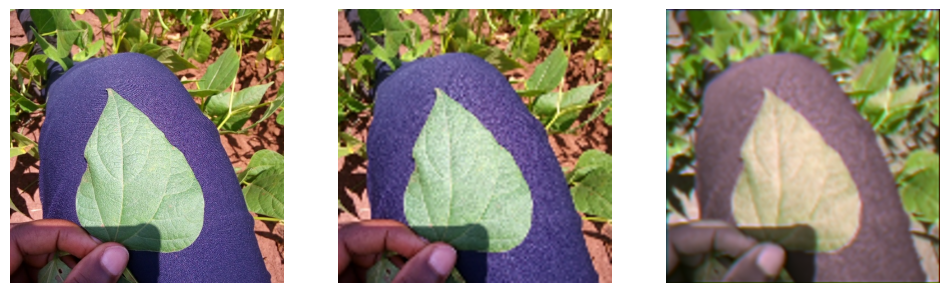

In [8]:
train_dataset_mapped = train_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE)
for x in train_data.take(10):
  fig=plt.figure(figsize=(12,4))

  plt.subplot(1,3,1)
  plt.imshow(x['image'].numpy())
  plt.axis('off')
  plt.subplot(1,3,2)
  lr=downsample_image(x['image'].numpy(),4)
  plt.imshow(lr.numpy())  
  plt.axis('off')
  plt.subplot(1,3,3)
  pred=SRCNN_915(np.array([lr]))
  plt.imshow(pred[0].numpy())
  plt.axis('off')
  plt.show()

2023-03-26 20:02:19.814853: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Output of layer 0


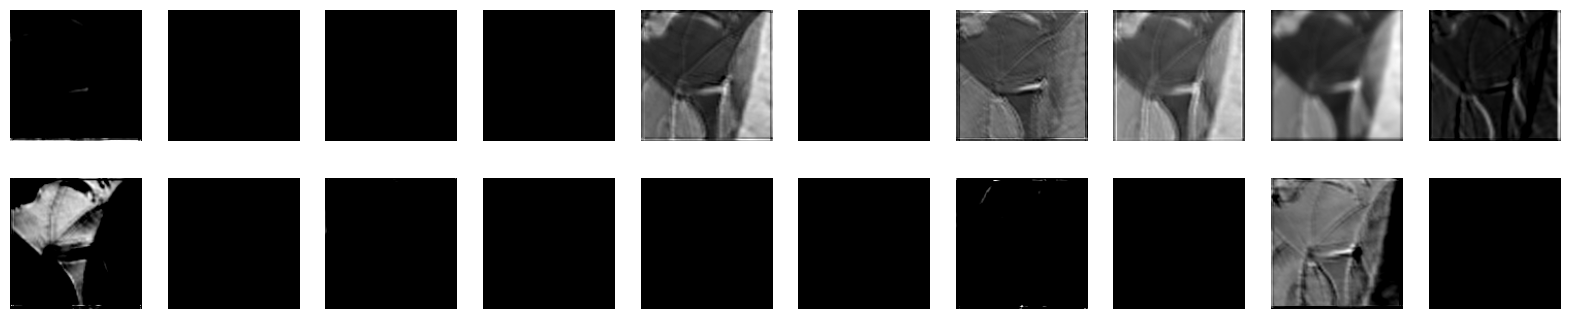

Output of layer 1


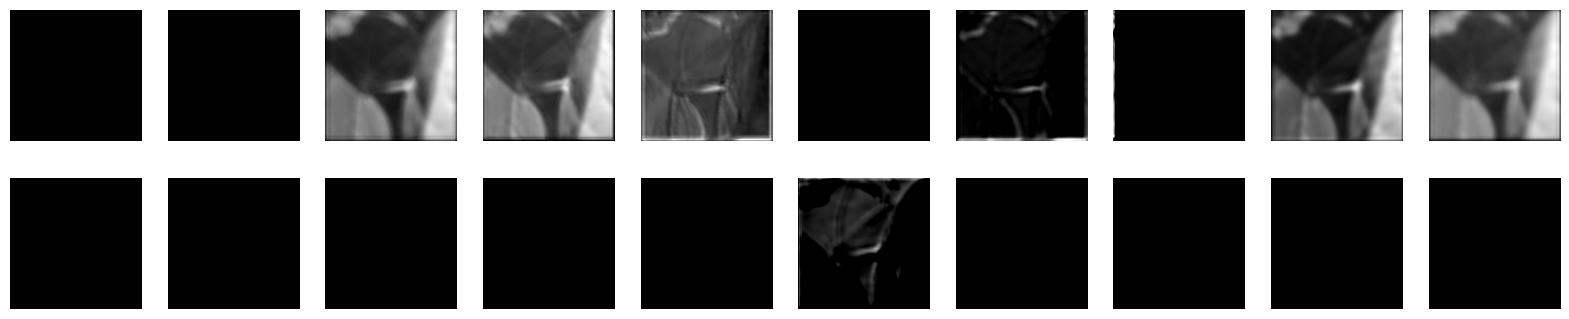

Output of layer 2


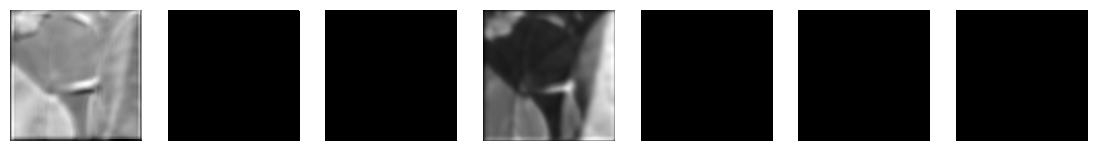

Output of layer 3


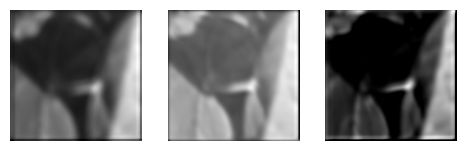

In [9]:
layers=SRCNN_915.layers
train_dataset_mapped = train_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE)

for x in train_dataset_mapped.take(1):
  image=x[0].numpy().reshape(1,128,128,3)
input_image_layer=layers[0].input

for idx,l in enumerate(layers):
  print("Output of layer",idx)
  intermediate_model=tf.keras.models.Model(input_image_layer,l.output)
  out=intermediate_model(image)
  fig = plt.figure(figsize=(20,4))
  
  for i in range( min(out.shape[-1], 20) ):
      plt.subplot(2, 10, i+1)
      plt.imshow(out[0, :, :, i] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.show()

![image](cnn.png)